### Описание эксперимента:
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле. 

### Метрика: 
Cредний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

### Важная информация
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)

Вам сказали, что его длительность должна составить 1 месяц.

Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

### Описание данных
- id_product -  идентификатор продукта, который был рекомендован
- is_pay - купил ли пользователь товар
- sum_payment - размер платежа (0, если не купил)
- city - город, в котором находится пользователь
- id_user - пользователь
- timestamp - timestamp события
- date - дата события

### Задачи, которые необходимо решить
Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. 

Посмотреть, есть ли выбросы в данных.

Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.

Рассчитать метрики из п2 по дням и построить их графики.

Принять решение о результате теста - обосновать.

### Дополнительно
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. 

Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import plotly.graph_objs as go
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("ab_made.gzip", compression='gzip')
df

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01
...,...,...,...,...,...,...,...,...
56400,1685485266,user_10740,0,A,Санкт-Петербург,14.0,0,2023-05-31
56401,1685481632,user_3589,0,B,Санкт-Петербург,1.0,0,2023-05-31
56402,1685514383,user_10664,13,A,Москва,17.0,1,2023-05-31
56403,1685481325,user_3537,0,B,Ярославь,19.0,0,2023-05-31


In [3]:
df_before = df[df['date'] < '2023-05-01']
print('Выбросов:', df_before[df_before['sum_payment'] > 500].shape[0])
df_before = df_before[df_before['sum_payment'] < 500]
df_before.sample(3)

Выбросов: 1


,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
19072,1682658059,user_7802,0,NaN,Рязань,3.0,0,2023-04-28
8905,1682185582,user_5285,0,NaN,Санкт-Петербург,4.0,0,2023-04-22
2304,1681274096,user_1594,0,NaN,Ярославь,20.0,0,2023-04-12


Посмотрим на статистики наших данных

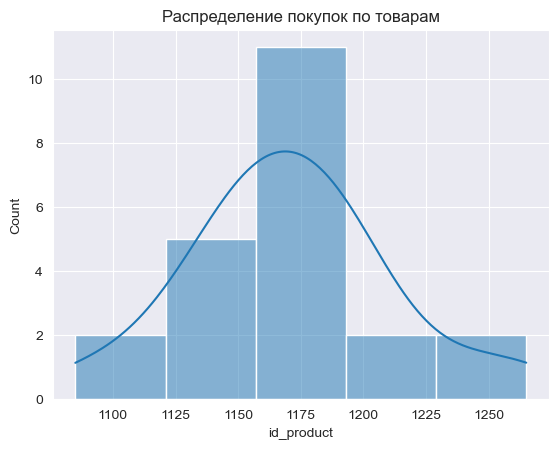

In [126]:
sns.histplot(df_before['id_product'].value_counts(), bins=5, kde=True)
plt.title('Распределение покупок по товарам');

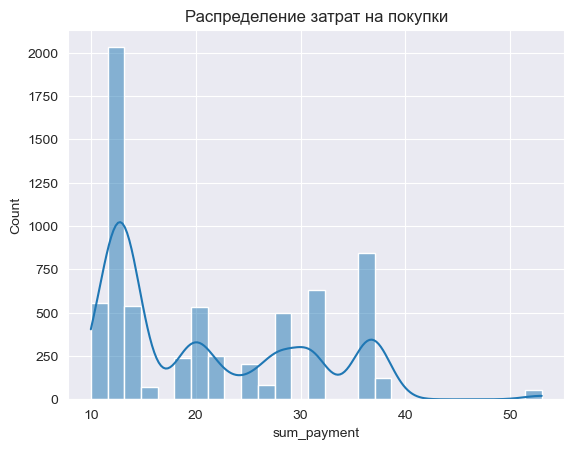

In [125]:
sns.histplot(df_before[df_before['sum_payment'] > 0]['sum_payment'], kde=True)
plt.title('Распределение затрат на покупки');

In [6]:
df_before['date'].value_counts().values

array([3850, 2543, 2109, 1893, 1633, 1437, 1278, 1136, 1116,  954,  871,
        779,  771,  691,  635,  593,  516,  464,  410,  394,  348,  315,
        272,  222,  139,  131,  110,   72,   60,   16])

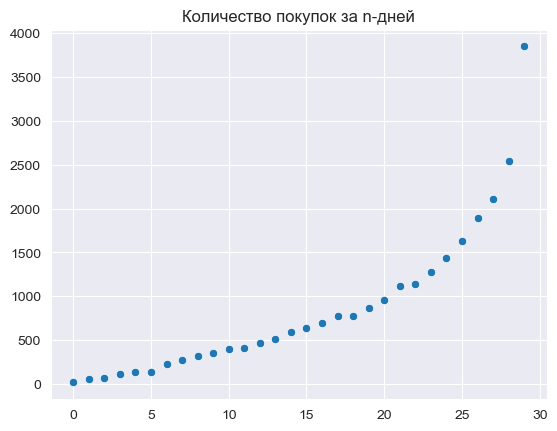

In [124]:
sns.scatterplot(df_before['date'].value_counts(ascending=True).values)
plt.title('Количество покупок за n-дней');

In [8]:
def get_metrics_per_day(df, date_end='2023-04-30'):
    x = []
    df_new = df.groupby(by=['id_user', 'date'])['sum_payment'].sum()
    # for user in tqdm_notebook(df['id_user'].unique()):
    for user in df['id_user'].unique():
        df_user =  df_new[user]
        date_start = df_user.index.min()
        if (pd.to_datetime(date_end) - pd.to_datetime(date_start)).days < 6:
            continue
        idx = pd.date_range(date_start, date_end)
        df_user.index = pd.DatetimeIndex(df_user.index)
        df_user = df_user.reindex(idx, fill_value=0)
        metrics = df_user.rolling(7).mean()[6:]

        x.extend(metrics.tolist())
        # x.append(metrics.mean())
    x = np.array(x)
    return x

In [9]:
x = get_metrics_per_day(df_before)
x.shape[0]

53840

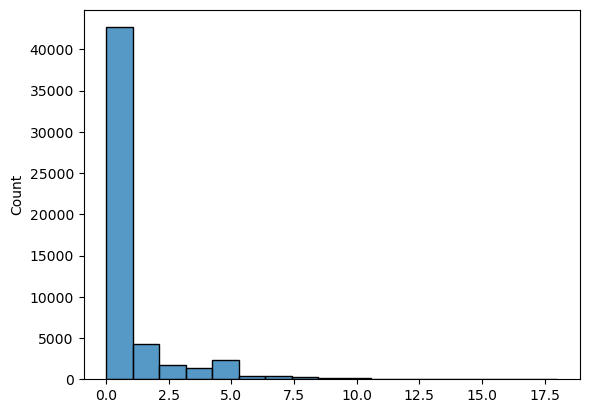

In [10]:
sns.histplot(x);

In [123]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k + 1) * z ** 2 * (sigma_1 ** 2 + sigma_2 ** 2 / k) / (delta_effect ** 2)
    return n


x_mean = x.mean()
x_sigma = x.std()
delta_effect = 0.1

dur = duration(k=1, delta_effect=delta_effect, sigma_1=x_sigma, sigma_2=x_sigma, alpha=0.05, beta=0.05)
print('Длительность теста:', round(dur), 'cэмплов (может быть достигнута за 2-3 недели)')

Длительность теста: 15749 cэмплов (может быть достигнута за 2-3 недели)


### 2.

In [12]:
df_ab = df[df['date'] >= '2023-05-01']
print('Выбросов:', df_ab[df_ab['sum_payment'] > 500].shape[0])
df_ab = df_ab[df_ab['sum_payment'] < 500]
df_ab.sample(3)

Выбросов: 2


,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
43501,1685139813,user_11367,0,B,Тула,5.0,0,2023-05-27
43739,1685210967,user_7567,0,B,Санкт-Петербург,5.0,0,2023-05-27
40671,1685101555,user_3273,0,B,Рязань,3.0,0,2023-05-26


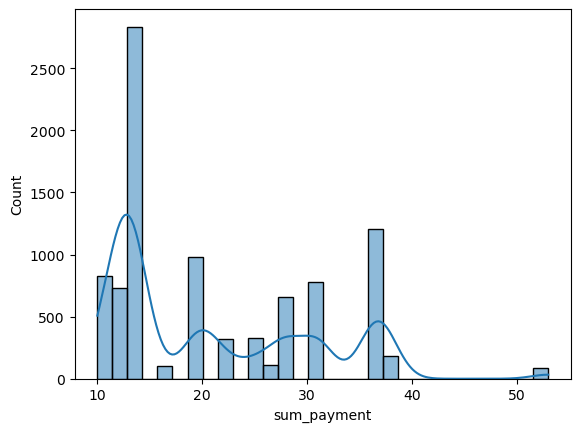

In [13]:
sns.histplot(df_ab[df_ab['sum_payment'] > 0]['sum_payment'], kde=True);

Избавились от выбросов заранее

In [14]:
df_a = df_ab[df_ab['group'] == 'A']
df_b = df_ab[df_ab['group'] == 'B']

In [15]:
df_a.id_user.unique().shape[0]

6000

In [16]:
df_b.id_user.unique().shape[0]

6000

In [17]:
df_a['city'].value_counts()

Рязань             4649
Москва             3165
Ярославь           3102
Санкт-Петербург    2971
Тула               1500
Name: city, dtype: int64

In [18]:
df_b['city'].value_counts()

Рязань             4740
Санкт-Петербург    3062
Москва             3010
Ярославь           2883
Тула               1562
Name: city, dtype: int64

Убедились, что выборки сбалансированы

### Тест за месяц

In [19]:
x_a = get_metrics_per_day(df_a, date_end='2023-05-31')
x_b = get_metrics_per_day(df_b, date_end='2023-05-31')

In [20]:
x_a.shape[0]

33944

In [21]:
x_b.shape[0]

33705

In [22]:
def get_bootstrap_sample_indices(sample_size: int, n_samples: int) -> np.ndarray:
    return np.random.randint(0, sample_size, (n_samples, sample_size))


def get_bootstrap_samples(X: np.ndarray, n_samples: int) -> np.ndarray:
    return X[get_bootstrap_sample_indices(len(X), n_samples)]


def bootstrap(x, alpha=0.05, plot=True):
    X_bootstrap = get_bootstrap_samples(x, n_samples=10_000)
    metrics_mean = np.mean(X_bootstrap, axis=1)

    CI_mean = np.percentile(metrics_mean, (alpha * 100, (1 - alpha) * 100))

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        sns.histplot(x_a, ax=axs[0], kde=True)
        sns.histplot(metrics_mean, ax=axs[1], kde=True)
        
        axs[0].axvline(metrics_mean.mean(), 0, 0.8, c='red')

        axs[1].axvline(CI_mean[0], 0, 0.4, c='red')
        axs[1].axvline(metrics_mean.mean(), 0, 0.8, c='red')
        axs[1].axvline(CI_mean[1], 0, 0.4, c='red')

        axs[0].set_title('Распределение')
        axs[0].set_ylabel('')
        axs[1].set_title(f'Среднее: {metrics_mean.mean():.3}, интервал: [{CI_mean[0]:.3}, {CI_mean[1]:.3}]')
        axs[1].set_ylabel('')
    
    return metrics_mean.mean(), CI_mean


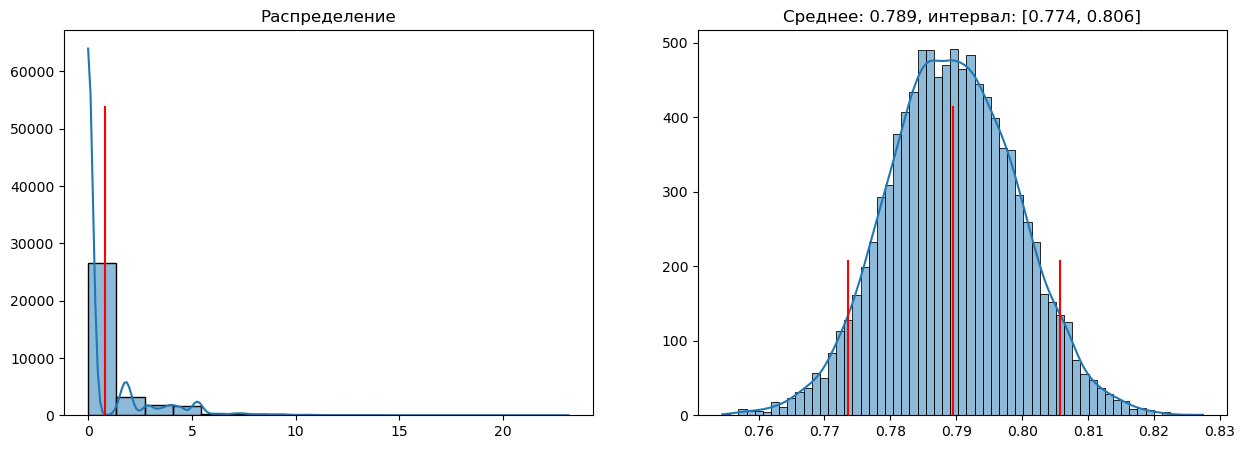

In [23]:
x_a_mean, x_a_CI = bootstrap(x_a)

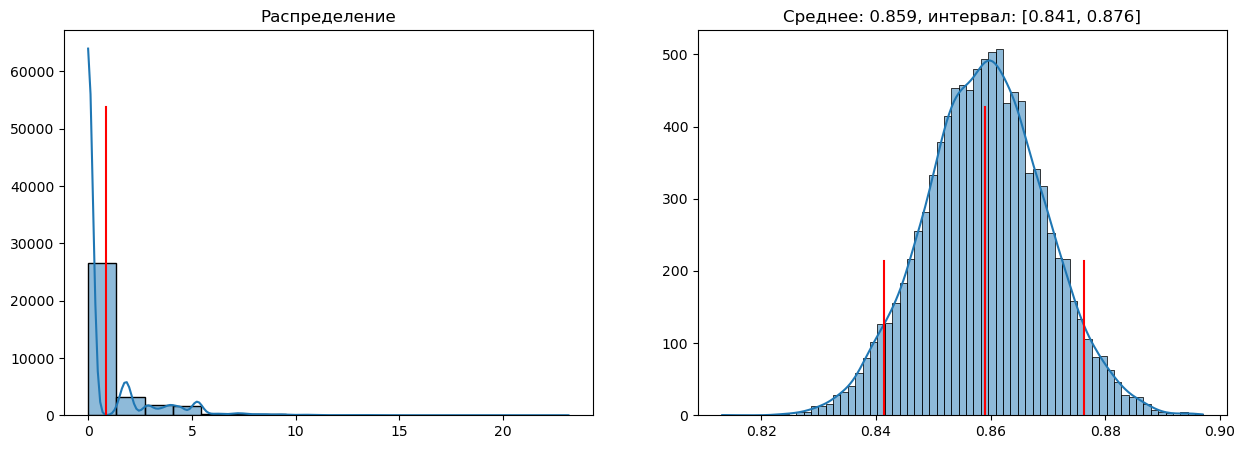

In [24]:
x_b_mean, x_b_CI = bootstrap(x_b)

In [118]:
pvalue = sps.ttest_ind(x_a, x_b, equal_var=True).pvalue
interval_a = x_b_mean - x_b_CI[0]
interval_b = x_b_mean - x_b_CI[0]
effect = (x_b_mean - x_a_mean) / x_a_mean * 100
pd.DataFrame({'Метрика': ['Средний чек за неделю'], 'A': [f'{x_a_mean:.2}+-{interval_a:.1}'], 'B': [f'{x_b_mean:.2}+-{interval_b:.1}'], 'Effect': [f'+{effect:.2}%'], 'p value': [pvalue]})

,Метрика,A,B,Effect,p value
0,Средний чек за неделю,0.79+-0.02,0.86+-0.02,+8.8%,0.000001


In [79]:
days = []
p_values = []
samples = []
x_a_means = []
x_b_means = []
CI_a = []
CI_b = []
for day in tqdm(range(7, 32)):
    x_a = get_metrics_per_day(df_a, date_end=f'2023-05-{day:02}')
    x_b = get_metrics_per_day(df_b, date_end=f'2023-05-{day:02}')
    
    p_value = sps.ttest_ind(x_a, x_b, equal_var=True).pvalue
    x_a_mean, x_a_CI = bootstrap(x_a, plot=False)
    x_b_mean, x_b_CI = bootstrap(x_b, plot=False)

    days.append(day)
    p_values.append(p_value)
    samples.append(x_a.shape[0] + x_b.shape[0])
    x_a_means.append(x_a_mean)
    x_b_means.append(x_b_mean)
    CI_a.append(x_a_CI)
    CI_b.append(x_b_CI)

100%|██████████| 25/25 [04:15<00:00, 10.23s/it]


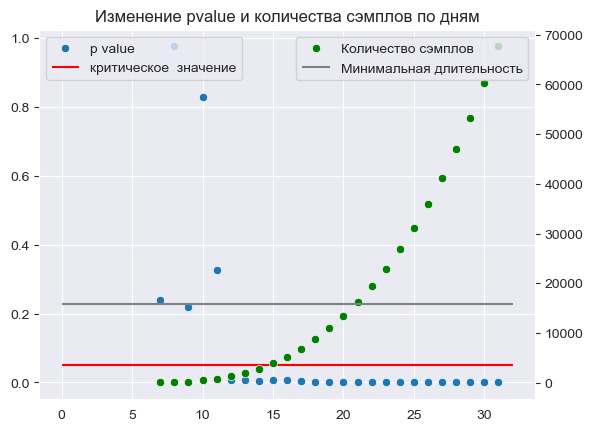

In [104]:
sns.set_style("darkgrid")
ax1 = sns.scatterplot(x=days, y=p_values)
ax1.hlines(0.05, xmin=0, xmax=32, color='red')
plt.legend(['p value', 'критическое  значение'], loc="upper left");

ax2 = ax1.twinx()
ax2.grid(False)
ax2 = sns.scatterplot(x=days, y=samples, color='green')
ax2.hlines(dur, xmin=0, xmax=32, color='gray')
plt.title('Изменение pvalue и количества сэмплов по дням');
plt.legend(['Количество сэмплов', 'Минимальная длительность'], loc="upper right");

По графику видно, что pvalue становится меньше критического раньше рассчитанной длительности теста, но тем не менее тест необходимо продолжать как минимум до рассчетного случая.

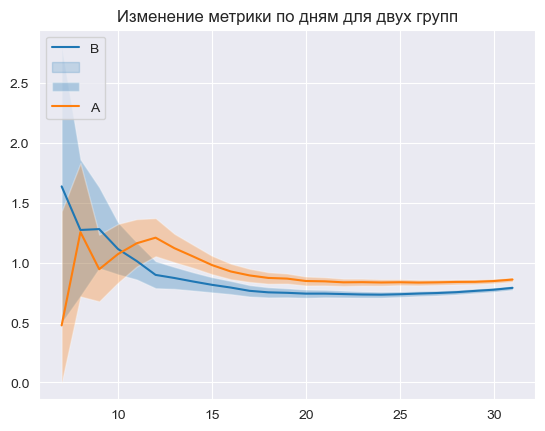

In [119]:
CI_a = np.array(CI_a)
CI_b = np.array(CI_b)


sns.lineplot(x=days, y=x_a_means)
plt.fill_between(days, CI_a[:, 0], CI_a[:, 1], alpha=.3)

sns.lineplot(x=days, y=x_b_means)
plt.fill_between(days, CI_b[:, 0], CI_b[:, 1], alpha=.3);

plt.title('Изменение метрики по дням для двух групп')
plt.legend(['B', '', '', 'A'], loc="upper left");

### Тест за 21 день

In [130]:
x_a = get_metrics_per_day(df_a, date_end='2023-05-21')
x_b = get_metrics_per_day(df_b, date_end='2023-05-21')
x_a_mean, x_a_CI = bootstrap(x_a, plot=False)
x_b_mean, x_b_CI = bootstrap(x_b, plot=False)

pvalue = sps.ttest_ind(x_a, x_b, equal_var=True).pvalue
interval_a = x_b_mean - x_b_CI[0]
interval_b = x_b_mean - x_b_CI[0]
effect = (x_b_mean - x_a_mean) / x_a_mean * 100
pd.DataFrame({'Метрика': ['Средний чек за неделю'], 'A': [f'{x_a_mean:.2}+-{interval_a:.1}'], 'B': [f'{x_b_mean:.2}+-{interval_b:.1}'], 'Effect': [f'+{effect:.3}%'], 'p value': [pvalue]})

,Метрика,A,B,Effect,p value
0,Средний чек за неделю,0.74+-0.03,0.84+-0.03,+13.9%,0.000234


### Вывод
По результатам теста новый алгоритм работает лучше старого, берем его в продакшен , т.к. эффект в 13.9% достаточен для целей сервиса.

Заметим, что после тестирования в течение месяца итоговый эффект меньше требуемого - 8.8%, возможно стоит продолжить тест на небольшой группе со старым алгоритмом на более долгий срок.